In [22]:
# import RS diffraction function
import numpy as np
from cmath import exp
from math import sqrt,pi
def diffrac(k, z, ratio, xy_range, XX, YY, U0):
    # Calculate rr
    rr = np.sqrt(XX**2 + YY**2 + z**2)
    
    # Calculate G
    G = 1 / (2 * np.pi) * np.exp(-1j * k * rr) / rr**2 * z * (1 / rr + 1j * k)
    
    # Create U0 with zeros
    U1 = np.zeros((2 * xy_range, 2 * xy_range), dtype=complex)
    U1[(xy_range // 2):((xy_range // 2) + xy_range),
       (xy_range // 2):((xy_range // 2) + xy_range)] = U0
    
    # Compute FFT of U0 and G
    fft_U1 = np.fft.fft2(U1)
    fft_G = np.fft.fft2(G)
    
    # Multiply FFT of U0 and G
    fft_U = fft_U1 * fft_G
    
    # Compute inverse FFT and shift
    U = np.fft.ifftshift(np.fft.ifft2(fft_U)) / ratio**2
    
    # Extract Eout from U
    Eout = U[(xy_range // 2):((xy_range // 2) + xy_range),
            (xy_range // 2):((xy_range // 2) + xy_range)]
    
    return Eout

In [23]:
#Calculates the PSF of a spherical wave from a point source at position (x0, y0, 0) to a plane at position z,U0: complex amplitude of the point source;dx,dy: pixel size of the observation plane in x,y direction,xx1,yy1: the x,y coordinate of the observation plane
def PSF_SW(U0, x0, y0, z, dx, dy, xx1, yy1, k):
    r = np.sqrt((xx1-x0)**2 + (yy1-y0)**2 + z**2)
    Uout = U0*np.exp(1j*k*r) / (1j*wavelength*r)#the complex amplitude of the wave at the observation plane
    return Uout

In [24]:
# Solves for the two distances z1 and z2 required to achieve the desired magnification M
def Z_Solve(f, M):
    z1 = f*(1+1/M)
    z2 = M*z1
    return z1, z2

In [25]:
#Applies a lens to a given input field.lens is the transmission function of the lens;LPW:size of the lens in pixels;SPW:size of the output field in pixels.
def lens_procession(U_before_lens, lens, LPW, SPW):
    U = U_before_lens * lens
    U_normalized = np.zeros((SPW, SPW))
    start = int((SPW - LPW) / 2)
    end = start + LPW
    U_normalized[start:end, start:end] = U #output field after the lens.
    return U_normalized

C:\Users\Akasha\AppData\Local\Temp\ipykernel_8152\784758730.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  U_normalized[start:end, start:end] = U #output field after the lens.


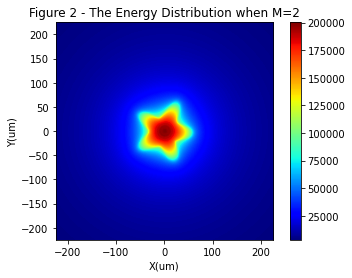

In [26]:
#main progrm
import numpy as np
from scipy import ndimage, fft
from skimage import io
import matplotlib.pyplot as plt

wavelength = 0.633
k = 2*np.pi/wavelength

# parameter of magnification
M_list = [1, 2, 6]

# parameter of lens
f = 100
d = 420

# parameter of range
img_width = 75
img_pixel_width = 300
m = 6

dx = img_width/img_pixel_width
dy = dx

lens_width = d
lens_pixel_width = int(d/dx)
screen_width = img_width*m
screen_half_width = screen_width/2
screen_pixel_width = img_pixel_width*m

LPW = lens_pixel_width
SPW = screen_pixel_width
IPW = img_pixel_width
SHW = screen_half_width

x = (np.arange(1, SPW+1) - (1+SPW)/2) * dx
y = x
xx, yy = np.meshgrid(x, y)
r = np.sqrt(xx**2 + yy**2)

x_lens = (np.arange(1, LPW+1) - (1+LPW)/2) * dx
y_lens = x_lens
xx_lens, yy_lens = np.meshgrid(x_lens, y_lens)
r_lens = np.sqrt(xx_lens**2 + yy_lens**2)

x_object = (np.arange(1, IPW+1) - (1+IPW)/2) * dx
y_object = x_object
xx_object, yy_object = np.meshgrid(x_object, y_object)
r_object = np.sqrt(xx_object**2 + yy_object**2)

# import the object
img = io.imread('raw.bmp')
object = img.astype('float64')/255.0

# import the lens
lens = np.exp(-1j * k/2/f * r_lens**2)
lens[r_lens > (d/2)] = 0

Indensity = np.zeros((SPW, SPW))

# Extension%
X = np.hstack((x[0] - x[::-1], x[::1] - x[0]))
Y = np.hstack((y[0] - y[::-1], y[::1] - y[0]))
XX, YY = np.meshgrid(X, Y)

for m_order in range(2, 3):
    M = M_list[m_order-1]
    z1, z2 = Z_Solve(f, M)
    for i in range(1, IPW+1):
        for j in range(1, IPW+1):
            if object[i-1, j-1] != 0:
                x1 = x_object[i-1]
                y1 = y_object[j-1]
                U_before_lens = PSF_SW(object[i-1, j-1], x1, y1, z1, dx, dy, xx_lens, yy_lens, k)
                U_after_lens = lens_procession(U_before_lens, lens, LPW, SPW)
                U_PSF = diffrac(k, z2, dx, SPW, XX,YY, U_after_lens)
                I_PSF = np.abs(U_PSF)**2
                Indensity += I_PSF
    str = f"Figure {m_order} - The Energy Distribution when M={M}"
    fig = plt.figure(m_order)
    plt.imshow(Indensity, extent=[-SHW, SHW, -SHW, SHW], cmap='jet')
    plt.colorbar()
    plt.title(str)
    plt.xlabel('X(um)')
    plt.ylabel('Y(um)')

plt.show()

m:1 x:1/300 y:1/300
m:1 x:1/300 y:2/300
m:1 x:1/300 y:3/300
m:1 x:1/300 y:4/300
m:1 x:1/300 y:5/300
m:1 x:1/300 y:6/300
m:1 x:1/300 y:7/300
m:1 x:1/300 y:8/300
m:1 x:1/300 y:9/300
m:1 x:1/300 y:10/300
m:1 x:1/300 y:11/300
m:1 x:1/300 y:12/300
m:1 x:1/300 y:13/300
m:1 x:1/300 y:14/300
m:1 x:1/300 y:15/300
m:1 x:1/300 y:16/300
m:1 x:1/300 y:17/300
m:1 x:1/300 y:18/300
m:1 x:1/300 y:19/300
m:1 x:1/300 y:20/300
m:1 x:1/300 y:21/300
m:1 x:1/300 y:22/300
m:1 x:1/300 y:23/300
m:1 x:1/300 y:24/300
m:1 x:1/300 y:25/300
m:1 x:1/300 y:26/300
m:1 x:1/300 y:27/300
m:1 x:1/300 y:28/300
m:1 x:1/300 y:29/300
m:1 x:1/300 y:30/300
m:1 x:1/300 y:31/300
m:1 x:1/300 y:32/300
m:1 x:1/300 y:33/300
m:1 x:1/300 y:34/300
m:1 x:1/300 y:35/300
m:1 x:1/300 y:36/300
m:1 x:1/300 y:37/300
m:1 x:1/300 y:38/300
m:1 x:1/300 y:39/300
m:1 x:1/300 y:40/300
m:1 x:1/300 y:41/300
m:1 x:1/300 y:42/300
m:1 x:1/300 y:43/300
m:1 x:1/300 y:44/300
m:1 x:1/300 y:45/300
m:1 x:1/300 y:46/300
m:1 x:1/300 y:47/300
m:1 x:1/300 y:48/300
m

C:\Users\Akasha\AppData\Local\Temp\ipykernel_8152\784758730.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  U_normalized[start:end, start:end] = U #output field after the lens.


m:1 x:40/300 y:145/300
m:1 x:40/300 y:146/300
m:1 x:40/300 y:147/300
m:1 x:40/300 y:148/300
m:1 x:40/300 y:149/300
m:1 x:40/300 y:150/300
m:1 x:40/300 y:151/300
m:1 x:40/300 y:152/300
m:1 x:40/300 y:153/300
m:1 x:40/300 y:154/300
m:1 x:40/300 y:155/300
m:1 x:40/300 y:156/300
m:1 x:40/300 y:157/300
m:1 x:40/300 y:158/300
m:1 x:40/300 y:159/300
m:1 x:40/300 y:160/300
m:1 x:40/300 y:161/300
m:1 x:40/300 y:162/300
m:1 x:40/300 y:163/300
m:1 x:40/300 y:164/300
m:1 x:40/300 y:165/300
m:1 x:40/300 y:166/300
m:1 x:40/300 y:167/300
m:1 x:40/300 y:168/300
m:1 x:40/300 y:169/300
m:1 x:40/300 y:170/300
m:1 x:40/300 y:171/300
m:1 x:40/300 y:172/300
m:1 x:40/300 y:173/300
m:1 x:40/300 y:174/300
m:1 x:40/300 y:175/300
m:1 x:40/300 y:176/300
m:1 x:40/300 y:177/300
m:1 x:40/300 y:178/300
m:1 x:40/300 y:179/300
m:1 x:40/300 y:180/300
m:1 x:40/300 y:181/300
m:1 x:40/300 y:182/300
m:1 x:40/300 y:183/300
m:1 x:40/300 y:184/300
m:1 x:40/300 y:185/300
m:1 x:40/300 y:186/300
m:1 x:40/300 y:187/300
m:1 x:40/30

TypeError: 'str' object is not callable

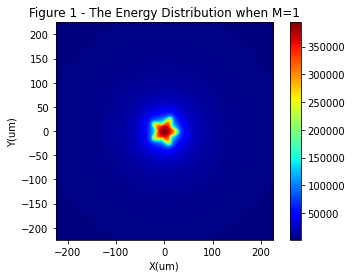

In [7]:
for m_order in range(1, 2):
    M = M_list[m_order-1]
    z1, z2 = Z_Solve(f, M)
    for i in range(1, IPW+1):
        for j in range(1, IPW+1):
            location = 'm:'+str(M)+' x:'+str(i)+'/'+str(IPW)+' y:'+str(j)+'/'+str(IPW)
            print(location)
            if object[i-1, j-1] != 0:
                x1 = x_object[i-1]
                y1 = y_object[j-1]
                U_before_lens = PSF_SW(object[i-1, j-1], x1, y1, z1, dx, dy, xx_lens, yy_lens, k)
                U_after_lens = lens_procession(U_before_lens, lens, LPW, SPW)
                U_PSF = diffrac(k, z2, dx, SPW, XX,YY, U_after_lens)
                I_PSF = np.abs(U_PSF)**2
                Indensity += I_PSF
    str = f"Figure {m_order} - The Energy Distribution when M={M}"
    fig = plt.figure(m_order)
    plt.imshow(Indensity, extent=[-SHW, SHW, -SHW, SHW], cmap='jet')
    plt.colorbar()
    plt.title(str)
    plt.xlabel('X(um)')
    plt.ylabel('Y(um)')

plt.show()

m:6 x:1/300 y:1/300
m:6 x:1/300 y:2/300
m:6 x:1/300 y:3/300
m:6 x:1/300 y:4/300
m:6 x:1/300 y:5/300
m:6 x:1/300 y:6/300
m:6 x:1/300 y:7/300
m:6 x:1/300 y:8/300
m:6 x:1/300 y:9/300
m:6 x:1/300 y:10/300
m:6 x:1/300 y:11/300
m:6 x:1/300 y:12/300
m:6 x:1/300 y:13/300
m:6 x:1/300 y:14/300
m:6 x:1/300 y:15/300
m:6 x:1/300 y:16/300
m:6 x:1/300 y:17/300
m:6 x:1/300 y:18/300
m:6 x:1/300 y:19/300
m:6 x:1/300 y:20/300
m:6 x:1/300 y:21/300
m:6 x:1/300 y:22/300
m:6 x:1/300 y:23/300
m:6 x:1/300 y:24/300
m:6 x:1/300 y:25/300
m:6 x:1/300 y:26/300
m:6 x:1/300 y:27/300
m:6 x:1/300 y:28/300
m:6 x:1/300 y:29/300
m:6 x:1/300 y:30/300
m:6 x:1/300 y:31/300
m:6 x:1/300 y:32/300
m:6 x:1/300 y:33/300
m:6 x:1/300 y:34/300
m:6 x:1/300 y:35/300
m:6 x:1/300 y:36/300
m:6 x:1/300 y:37/300
m:6 x:1/300 y:38/300
m:6 x:1/300 y:39/300
m:6 x:1/300 y:40/300
m:6 x:1/300 y:41/300
m:6 x:1/300 y:42/300
m:6 x:1/300 y:43/300
m:6 x:1/300 y:44/300
m:6 x:1/300 y:45/300
m:6 x:1/300 y:46/300
m:6 x:1/300 y:47/300
m:6 x:1/300 y:48/300
m

C:\Users\Akasha\AppData\Local\Temp\ipykernel_6764\784758730.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  U_normalized[start:end, start:end] = U #output field after the lens.


m:6 x:40/300 y:145/300
m:6 x:40/300 y:146/300
m:6 x:40/300 y:147/300
m:6 x:40/300 y:148/300
m:6 x:40/300 y:149/300
m:6 x:40/300 y:150/300
m:6 x:40/300 y:151/300
m:6 x:40/300 y:152/300
m:6 x:40/300 y:153/300
m:6 x:40/300 y:154/300
m:6 x:40/300 y:155/300
m:6 x:40/300 y:156/300
m:6 x:40/300 y:157/300
m:6 x:40/300 y:158/300
m:6 x:40/300 y:159/300
m:6 x:40/300 y:160/300
m:6 x:40/300 y:161/300
m:6 x:40/300 y:162/300
m:6 x:40/300 y:163/300
m:6 x:40/300 y:164/300
m:6 x:40/300 y:165/300
m:6 x:40/300 y:166/300
m:6 x:40/300 y:167/300
m:6 x:40/300 y:168/300
m:6 x:40/300 y:169/300
m:6 x:40/300 y:170/300
m:6 x:40/300 y:171/300
m:6 x:40/300 y:172/300
m:6 x:40/300 y:173/300
m:6 x:40/300 y:174/300
m:6 x:40/300 y:175/300
m:6 x:40/300 y:176/300
m:6 x:40/300 y:177/300
m:6 x:40/300 y:178/300
m:6 x:40/300 y:179/300
m:6 x:40/300 y:180/300
m:6 x:40/300 y:181/300
m:6 x:40/300 y:182/300
m:6 x:40/300 y:183/300
m:6 x:40/300 y:184/300
m:6 x:40/300 y:185/300
m:6 x:40/300 y:186/300
m:6 x:40/300 y:187/300
m:6 x:40/30

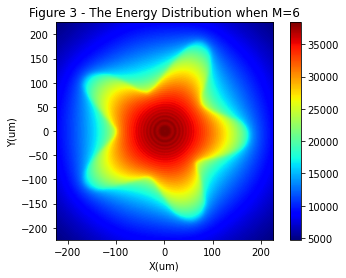

In [10]:
for m_order in range(3, 4):
    M = M_list[m_order-1]
    z1, z2 = Z_Solve(f, M)
    for i in range(1, IPW+1):
        for j in range(1, IPW+1):
            location = 'm:'+str(M)+' x:'+str(i)+'/'+str(IPW)+' y:'+str(j)+'/'+str(IPW)
            print(location)
            if object[i-1, j-1] != 0:
                x1 = x_object[i-1]
                y1 = y_object[j-1]
                U_before_lens = PSF_SW(object[i-1, j-1], x1, y1, z1, dx, dy, xx_lens, yy_lens, k)
                U_after_lens = lens_procession(U_before_lens, lens, LPW, SPW)
                U_PSF = diffrac(k, z2, dx, SPW, XX,YY, U_after_lens)
                I_PSF = np.abs(U_PSF)**2
                Indensity += I_PSF
    str = f"Figure {m_order} - The Energy Distribution when M={M}"
    fig = plt.figure(m_order)
    plt.imshow(Indensity, extent=[-SHW, SHW, -SHW, SHW], cmap='jet')
    plt.colorbar()
    plt.title(str)
    plt.xlabel('X(um)')
    plt.ylabel('Y(um)')

plt.show()
